In [ ]:
#tbd

In [8]:
import numpy as np
import polars as pl
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import optuna
import shap

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import time
import math
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
# load data
dataset = pl.read_parquet("../data/clean/dataset.parquet")
sbmssn = pl.read_parquet("../data/clean/sbmssn.parquet")

dataset.shape

(8585, 701)

In [3]:
# lgbm data format
lgb_data_train = lgb.Dataset(data=dataset.drop(['target']).to_pandas(), label=dataset.get_column('target').to_pandas())

In [5]:
# fit the model with the tuned param and 10-fold cv for the boosting iterations
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'learning_rate': 0.005,
    'num_leaves': 39,
    'feature_fraction': 0.6,
    'bagging_fraction': 1,
    'cat_l2': 14.4,
    'cat_smooth': 12,
    'verbosity': -1,
    'seed': 0
}

cv = lgb.cv(
    params=params,
    num_boost_round=5000,
    train_set=lgb_data_train,
    nfold=10,
    seed=0,
    eval_train_metric=True,
    stratified=False
)

In [6]:
optimal_rounds = np.argmin(cv['valid rmse-mean'])
best_cv_score = min(cv['valid rmse-mean'])

print("\nOptimal Round: {}\nOptimal Score: {} + {}".format(
    optimal_rounds, best_cv_score, cv['valid rmse-stdv'][optimal_rounds]))


Optimal Round: 2098
Optimal Score: 9.283727463087626 + 0.21577668538012398


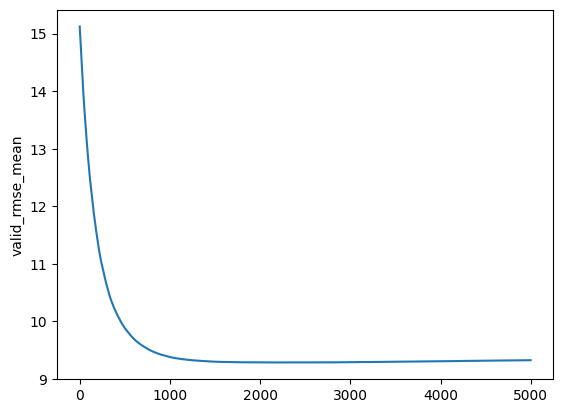

In [10]:
# plot cross-validated line
pltdat = pd.DataFrame({'valid_rmse_mean': cv['valid rmse-mean']})

ax = sns.lineplot(data=pltdat, x=pltdat.index, y="valid_rmse_mean", ci=None)

In [37]:
params.update({'num_iterations': 1998})

bst = lgb.train(
    params=params,
    train_set=lgb_data_train,
)

In [38]:
# create final predictions
df_to_predict = sbmssn.drop('child_id').to_pandas()
sbmssn_pred = bst.predict(df_to_predict)

In [39]:
# explain final model
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dataset.drop(['target']).to_pandas())

AssertionError: Feature and SHAP matrices must have the same number of rows!

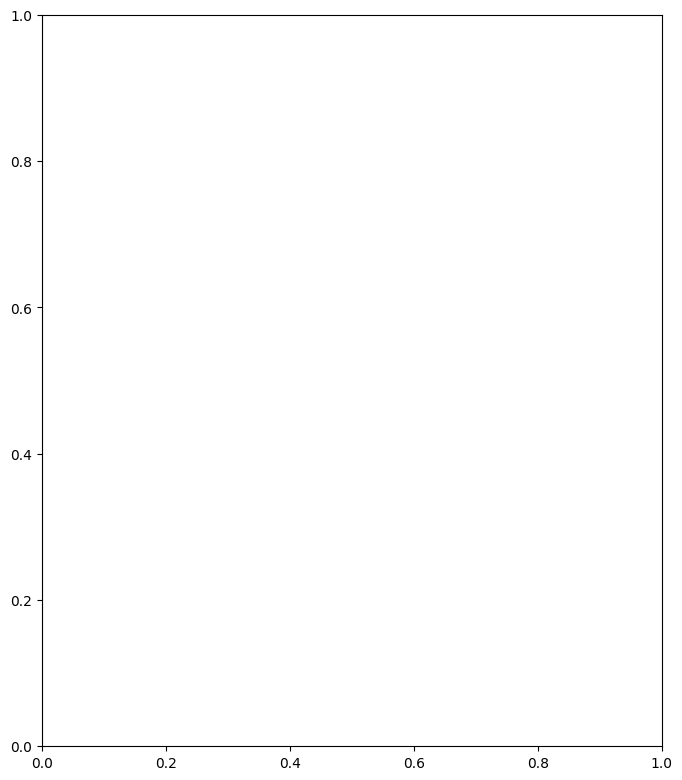

In [44]:
shap.summary_plot(shap_values, dataset.drop(['target']).to_pandas())

In [ ]:
# visualize all the training set predictions
shap.plots.force(explainer.expected_value, shap_values)

In [43]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values=shap_values)

ValueError: the beeswarm plot requires Explanation object as the `shap_values` argument

In [40]:
ft = {
    'feature_1': [], 'feature_2': [], 'feature_3': [], 'feature_4': [], 'feature_5': [], 'feature_6': [], 'feature_7': [],
    'feature_8': [], 'feature_9': [], 'feature_10': [], 'feature_11': [], 'feature_12': [], 'feature_13': [], 'feature_14': [],
    'feature_15': []
}

shap_values = explainer.shap_values(df_to_predict)

for sv in shap_values: 
    arr = np.argsort(sv)[::-1][:15]
    for ind, a in enumerate(arr):
        place = f'feature_{ind+1}'
        ft[place].append(df_to_predict.columns[a])

final_sub = sbmssn.select('child_id')
final_sub = final_sub.with_columns(pl.Series(sbmssn_pred).alias('target'))

ft = pl.DataFrame(ft)
final_sub = pl.concat([final_sub, ft], how='horizontal')

fname = '../submission/' + time.strftime("%Y%m%d-%H%M%S") + '.csv'
final_sub.write_csv(fname)

In [ ]:
# sensitivity analysis